### Goal
This notebook is to solve section 2 of http://rll.berkeley.edu/deeprlcourse/f17docs/hw1fall2017.pdf. 


### Data
``` bash
$ python run_expert.py experts/Humanoid-v1.pkl Humanoid-v1 humanoid_rollouts_50.pkl  --num_rollouts 50
```


### Algo
``` python
rollouts = load_rollouts(fl)
model = train_model(rollouts)
simulate(model, rollouts['envname'])
```

In [54]:
%matplotlib inline

from __future__ import division
from __future__ import unicode_literals

import torch as tc
from torch.utils import data as tc_data_utils

import pandas as pd
import tqdm

from matplotlib import pyplot as plt
from IPython.display import display, HTML

import model_utils

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize']= (15,15)

pd.options.display.max_colwidth = 75
pd.options.display.width = 150
pd.options.display.max_columns = 40
css = open('/nail/home/visp/ipython/style-table.css').read()
HTML('<style>{}</style>'.format(css))

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
ROLLOUT_FL = 'humanoid_rollouts_50.pkl'

### Load rollouts

In [14]:
rolls = model_utils.load_rollouts(fl=ROLLOUT_FL)

obs.shape:  (49108, 376) , axns.shape,  (49108, 17)


### Data preprocessing

#### State space

In [15]:
obs_df = pd.DataFrame(rolls.obs)
obs_df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,...,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375
count,49108.000000,49108.000000,49108.000000,49108.000000,49108.000000,49108.000000,49108.000000,49108.000000,49108.000000,49108.000000,49108.000000,49108.000000,49108.000000,49108.000000,49108.000000,49108.000000,49108.000000,49108.000000,49108.000000,49108.000000,...,49108.0,49108.0,49108.0,49108.0,49108.0,49108.0,49108.0,49108.0,49108.0,49108.0,49108.0,49108.0,49108.0,49108.0,49108.0,49108.0,49108.0,49108.0,49108.0,49108.0
mean,1.154224,0.962815,0.061848,-0.051544,0.211251,-0.416141,0.136630,-0.161627,0.066482,0.101884,-0.135889,-1.440099,-0.021945,0.018302,-0.334696,-1.548281,0.422352,-0.549812,-1.472751,1.292748,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.036751,0.029814,0.030233,0.053757,0.131094,0.219348,0.109782,0.116586,0.070513,0.217497,0.504558,0.903793,0.185797,0.139231,0.612610,0.885447,0.141221,0.380895,0.450343,0.446874,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.002468,0.796261,-0.082053,-0.264600,-0.216725,-0.866652,-0.486728,-0.622469,-0.325325,-0.665067,-1.390797,-2.931557,-0.508680,-0.431947,-1.642722,-2.950705,-0.124461,-1.557796,-1.669430,-0.733596,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.134484,0.940283,0.040951,-0.083866,0.096568,-0.592220,0.074232,-0.254425,0.060477,-0.048167,-0.556857,-2.336316,-0.142072,-0.085777,-0.837245,-2.416887,0.329454,-0.800238,-1.576199,1.348125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,1.149146,0.973313,0.062081,-0.052190,0.201935,-0.414792,0.143827,-0.152391,0.092947,0.124812,-0.098744,-1.239963,0.070606,0.002192,-0.350266,-1.402361,0.411819,-0.507653,-1.575275,1.481841,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.164930,0.987896,0.083026,-0.019460,0.328468,-0.252529,0.206970,-0.073924,0.100792,0.260655,0.375833,-0.715756,0.104350,0.113885,0.293935,-0.833593,0.502861,-0.266537,-1.574378,1.489854,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.409792,0.999998,0.191657,0.269871,0.600877,0.529383,0.550811,0.324256,0.197158,0.666482,0.617750,0.358403,0.246755,0.496321,0.592130,0.358865,1.114573,0.666763,0.954694,1.600033,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
num_non_zeros = (obs_df != 0).sum(axis=0)
allzeroinds = num_non_zeros[(num_non_zeros==0)].index.values
print 'allzeroinds: ', allzeroinds, '\ncnt: ', len(allzeroinds)

allzeroinds:  [ 45  46  47  48  49  50  51  52  53  54 185 186 187 188 189 190 269 270
 271 272 273 274 292 293 294 295 296 297 298 299 300 301 302 303 304 305
 306 307 308 309 352 353 354 355 356 357 358 359 360 361 362 363 364 365
 366 367 368 369 370 371 372 373 374 375] 
cnt:  64


#### Visualize the action space

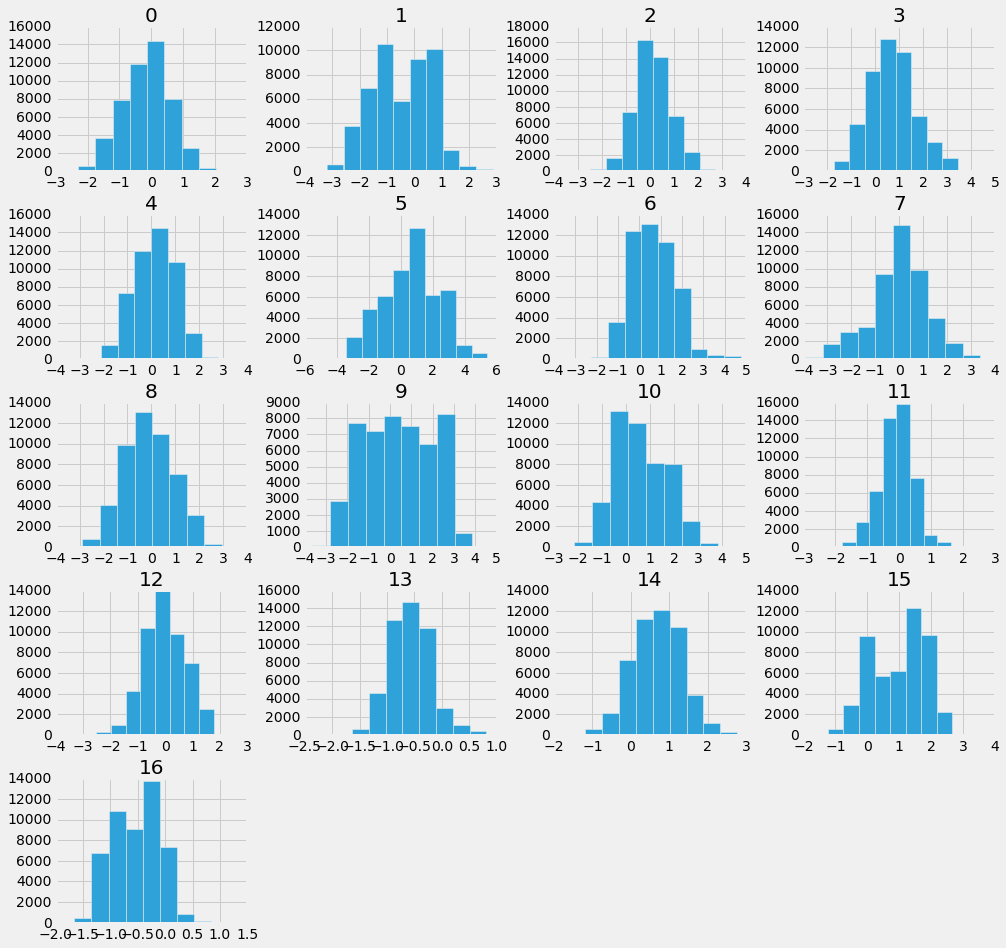

In [17]:
axns_df = pd.DataFrame(rolls.axns)
_ = axns_df.hist()

**Note**: It might useful to stdize the action space and then learn and then map back to the original space.

In [18]:
dataloader = model_utils.RollDataLoader(rolls=rolls)

In [25]:
D_in, D_out = rolls.obs.shape[1], rolls.axns.shape[1]
D_in, D_out

(376, 17)

## Model

### Model v0: Directly learn output with simple 2 layer NN with w^T.x output and RMSE error.

In [29]:
H = 100
EPOCHS = 200
losses = None

In [40]:
model = tc.nn.Sequential(
    tc.nn.Linear(D_in, H),
    tc.nn.ReLU(),
    tc.nn.Linear(H, D_out),
)
loss_fn = tc.nn.MSELoss()
optimizer = tc.optim.Adam(params=model.parameters(), lr=1e-2)
print 'Model:', model, '\nLoss fn:', loss_fn, '\nOptimizer:', optimizer

Model: Sequential (
  (0): Linear (376 -> 100)
  (1): ReLU ()
  (2): Linear (100 -> 17)
) 
Loss fn: MSELoss (
) 
Optimizer: <torch.optim.adam.Adam object at 0x11ec09e50>


In [41]:
losses = model_utils.train_model(
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    dataloader=dataloader,
    epochs=EPOCHS,
    prev_losses=losses,
)

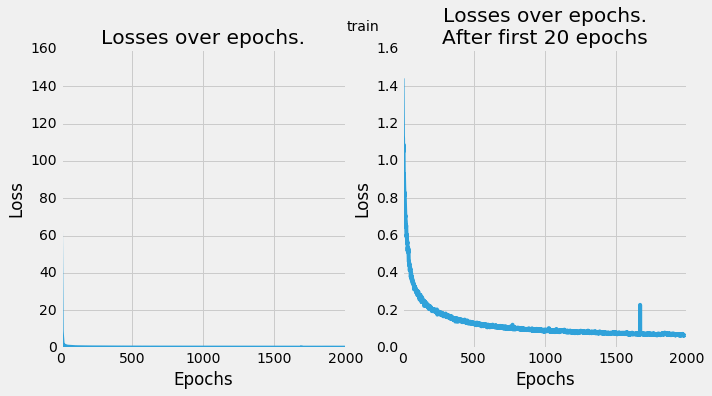

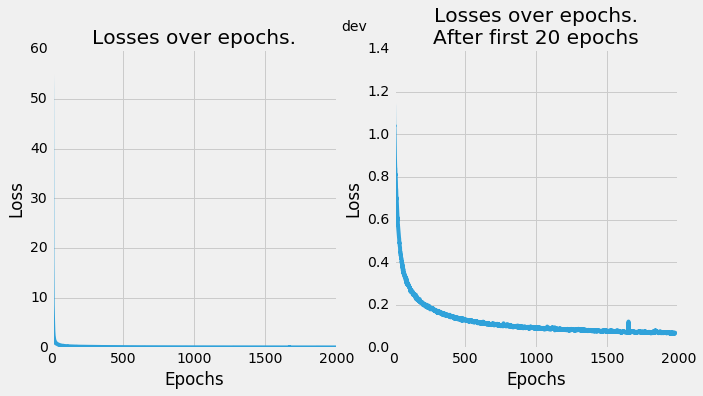

In [51]:
model_utils.plot_loss(losses=losses)

In [55]:
model_utils.save_model(path='./humanoid_bc.pkl', model=model)